In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import ultraplot as pplt

########## load fortran data ##########
R = 0.49 #radius of the tank (m)
f = 2*7.8540 #Coriolis parameter (1/s)

isnum = True #1 if QG simulation, 0 if experiment
adimfac = R if isnum else 1.0 #factor to multiply distances by in case of QG simulations

npa = 4000 # number particles
nt = 3000 #number time steps
dt = 0.05 #time step in seconds
dt = 0.77664353/f #time step in seconds for QG at E=12e-8
dt = 0.61627843/f #time step in seconds for QG at E-06e-8
#dt = 0.76906991/f #time step in seconds for QG at E-02e-8

filepath = '/home/dgsl1/Documents/GitHub/xdispersion/data_daphne/QGdaphne-E12e-8/fort.2001'
#df = pd.read_csv(f'/home/dgsl1/Documents/GitHub/xdispersion/data_daphne/QGdaphne-E06e-8/fort.1001', sep='\s+', header=None, names=['x', 'y'])
df = pd.read_csv(filepath, sep='\s+', header=None, names=['x', 'y'])
data = df.values.reshape([npa, nt, 2])

# Compute the x and y velocities along time axis
dx = np.diff(data[..., 0], axis=1)  # shape (1000, 200)
dy = np.diff(data[..., 1], axis=1)  # shape (1000, 200)

# To match shape (1000, 201), pad with a zero velocity at the end (or beginning)
vx = 1/dt*np.concatenate([dx, np.zeros((data.shape[0], 1))], axis=1)  # shape (1000, 201)
vy = 1/dt*np.concatenate([dy, np.zeros((data.shape[0], 1))], axis=1)  # shape (1000, 201)

# Expand last axis to concatenate along last dimension
vx = vx[..., np.newaxis]
vy = vy[..., np.newaxis]

# Concatenate position and velocity to get final shape (1000, 201, 4)
data3 = np.concatenate([data, vx, vy], axis=-1)

# Extract initial positions
x0 = data3[:, 0, 0]  # x at time=0
y0 = data3[:, 0, 1]  # y at time=0

# Compute initial radius
r0 = np.sqrt(x0**2 + y0**2)

# Create mask for valid particles (inside the tank radius)
mask = r0 < R/adimfac  # keep only particles where x0^2 + y0^2 < 0.49

# Apply the mask to filter data3
data3_filtered = data3[mask, :, :]

# Optional: update npa if needed
npa_filtered = data3_filtered.shape[0]

print(data.shape)
print(data3.shape)
print(data3_filtered.shape)
print(adimfac)

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_17664/974976123.py:22: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(filepath, sep='\s+', header=None, names=['x', 'y'])


(4000, 3000, 2)
(4000, 3000, 4)
(3395, 3000, 4)
0.49


Saved NetCDF to: /home/dgsl1/Documents/GitHub/xdispersion/data_daphne/QGdaphne-E12e-8/fort.2001.np4000nt3000.nc


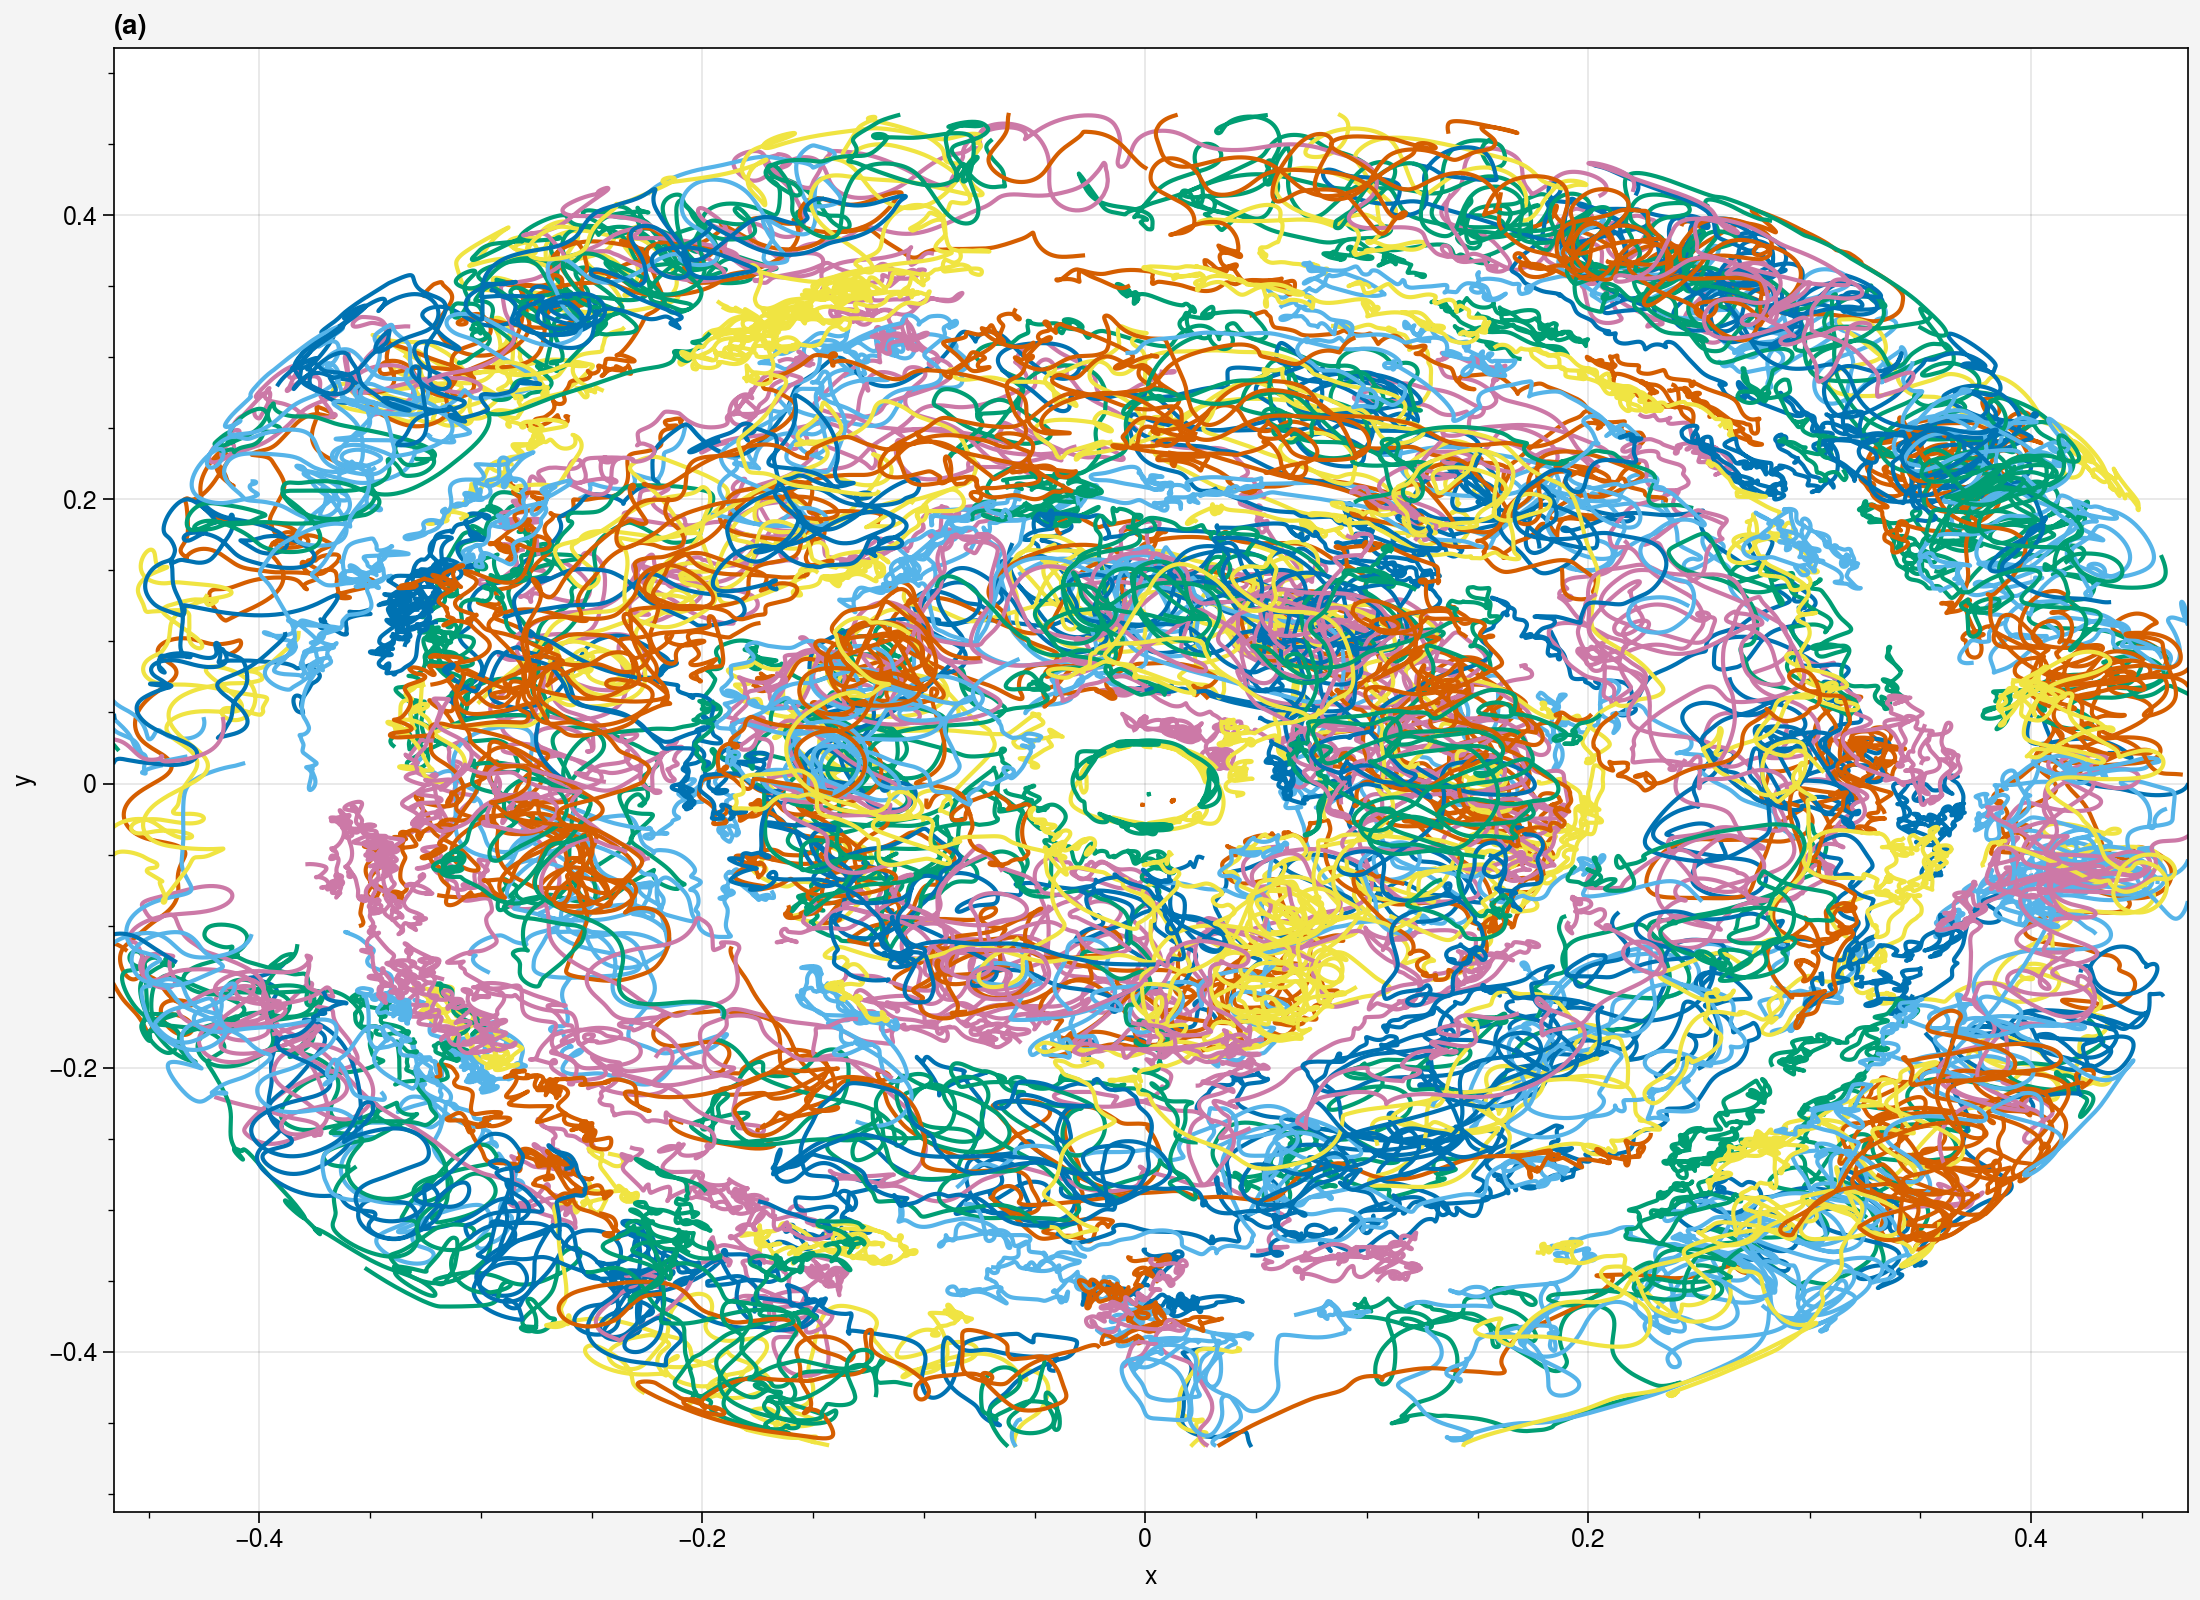

In [3]:
import os 

x = xr.DataArray(adimfac*data3_filtered[:,:,0], name='x', dims=['tracer', 'time'], coords={'tracer':np.arange(npa_filtered), 'time':dt*np.arange(nt)})
y = xr.DataArray(adimfac*data3_filtered[:,:,1], name='y', dims=['tracer', 'time'], coords={'tracer':np.arange(npa_filtered), 'time':dt*np.arange(nt)})
ux = xr.DataArray(adimfac*data3_filtered[:,:,2], name='ux', dims=['tracer', 'time'], coords={'tracer':np.arange(npa_filtered), 'time':dt*np.arange(nt)})
uy = xr.DataArray(adimfac*data3_filtered[:,:,3], name='uy', dims=['tracer', 'time'], coords={'tracer':np.arange(npa_filtered), 'time':dt*np.arange(nt)})

# Create particle ID variable (1 to npa), int32
ID = xr.DataArray(np.arange(1, npa_filtered + 1, dtype=np.int32), name='ID', dims=['tracer'], coords={'tracer': np.arange(npa_filtered)})

########## convert to netcdf file and save ##########

# Automatically get the directory and filename
data_dir = os.path.dirname(filepath)
filename = os.path.basename(filepath)

# Create filename using inferred values
nc_filename = f"{filename}.np{npa}nt{nt}.nc"
nc_path = os.path.join(data_dir, nc_filename)

# Save to NetCDF
dset = xr.merge([ID, x, y, ux, uy])
dset.to_netcdf(nc_path)
print(f"Saved NetCDF to: {nc_path}")

#dset = xr.merge([ID, x, y, ux, uy])
#dset.to_netcdf(f'/home/dgsl1/Documents/GitHub/xdispersion/data_daphne/QGdaphne-E12e-8/fort.1001.np4000nt1001.nc')

########## plot the trajectory ##########

fig, axes = pplt.subplots(figsize=(11, 8), sharex=3, sharey=3)
ax = axes[0]
ax.plot(x[::10].T, y[::10].T)
axes.format(abc='(a)')
